In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
import os
import os.path as osp
import pandas as pd
sys.path.insert(1, osp.abspath('../'))

## BoundingBoxDataset example

In [39]:
from modules.torch_dataset.bounding_box_dataset import BoundingBoxDataset

det_df = pd.read_csv("/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20/annotations/S01/c001/gt.txt")[:0]
ds = BoundingBoxDataset(det_df, 
                        frame_dir="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20/frames/S01/c001",
                        frame_width=1080, 
                        frame_height=1920, 
                        output_size=(224, 224),
                        fully_qualified_dir=True,
                        return_det_ids_and_frame=True,
                        mode='train',
                        augmentation=None)

In [40]:
from torch.utils.data import DataLoader  
bb_loader = DataLoader(ds, 
                        batch_size=32, 
                        pin_memory=True, 
                        num_workers=2)

In [10]:
frame_num, det_id, camera, sequence, bboxes = ds[0]

In [11]:
bboxes

tensor([[[ 1.1187,  1.1358,  0.7419,  ..., -0.4911, -0.4911, -0.4911],
         [ 1.1872,  1.2214,  0.9817,  ..., -0.4911, -0.4911, -0.4911],
         [ 1.1700,  1.2899,  1.1872,  ..., -0.4739, -0.4739, -0.4739],
         ...,
         [ 0.7248,  0.7248,  0.7248,  ...,  0.6221,  0.6221,  0.6221],
         [ 0.7248,  0.7248,  0.7248,  ...,  0.6221,  0.6221,  0.6221],
         [ 0.7077,  0.7248,  0.7248,  ...,  0.6221,  0.6221,  0.6221]],

        [[ 1.1155,  1.0980,  0.6954,  ..., -0.4251, -0.4251, -0.4251],
         [ 1.1856,  1.1856,  0.9580,  ..., -0.4426, -0.4426, -0.4426],
         [ 1.1681,  1.2731,  1.1681,  ..., -0.4251, -0.4251, -0.4251],
         ...,
         [ 0.8704,  0.8704,  0.8704,  ...,  0.7654,  0.7654,  0.7654],
         [ 0.8704,  0.8704,  0.8704,  ...,  0.7654,  0.7654,  0.7654],
         [ 0.8529,  0.8704,  0.8704,  ...,  0.7654,  0.7654,  0.7654]],

        [[ 0.8622,  0.9494,  0.5834,  ..., -0.3230, -0.3230, -0.3230],
         [ 0.9319,  1.0365,  0.8099,  ..., -0

## SequenceGraphDataset example

In [ ]:
from modules.torch_dataset.sequence_graph_dataset import SequenceGraphDataset

dataset = SequenceGraphDataset(sequence_path_prefix='datasets/AIC20', 
                               sequence_names=['S01', 'S03', 'S04'], 
                                annotations_filename='gt.txt')

data = dataset[0]     # Access the first processed graph

In [5]:
import pandas as pd
edge = pd.read_json("datasets/AIC20/logs/S03/sequence_graph_edges.json")
edge.head()

,src_node_id,dst_node_id,src_obj_id,dst_obj_id,edge_labels
0,0,14,252,252,1
1,0,15,252,242,0
2,0,16,252,256,0
3,0,17,252,246,0
4,0,18,252,247,0


In [37]:
edge[(edge.src_obj_id == edge.dst_obj_id)].head()

,src_node_id,dst_node_id,src_obj_id,dst_obj_id,edge_labels
0,0,14,252,252,1
17,0,31,252,252,1
31,0,45,252,252,1
48,0,62,252,252,1
67,1,15,242,242,1


## ObjectGraphDataset example

In [4]:
from models.reid.resnet import resnet101_ibn_a
model = resnet101_ibn_a(model_path="/Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth", device="cpu")

Loading pretrained model from /Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth


In [5]:
import torchvision.transforms.v2 as transforms
augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomErasing(scale=(0.02, 0.15)),
        transforms.RandomRotation(degrees=0.15),
        transforms.RandomPerspective(distortion_scale=0.25)
    ])

In [6]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np

data_df = AnnotationsProcessor(sequence_path='/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20', annotations_filename='gt.txt').consolidate_annotations(['S02'])
ids = np.random.choice(data_df.id.unique(), 20)
data_df = data_df[data_df.id.isin(ids)]

dataset = ObjectGraphDataset(data_df, 
                             sequence_path_prefix="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20", 
                             sequence_names=['S02'], 
                             annotations_filename='gt.txt', 
                             reid_model=model,
                             num_ids_per_graph=-1, 
                             embeddings_per_it=48, 
                             resized_img_shape=(224, 224), 
                             orignal_img_shape=(1920, 1080), 
                             augmentation=None,
                             return_dataframes=False)

Sampling object ids


In [91]:
data = dataset[0]

Computing embeddings


100%|██████████| 46/46 [07:29<00:00,  9.77s/it]

Generating nodes
Generating edges
Creating PyG graph


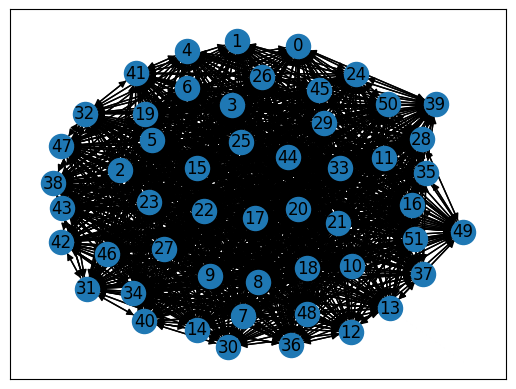

In [92]:
from torch_geometric.utils.convert import to_networkx, from_networkx
import networkx as nx
network = to_networkx(data)
nx.draw_networkx(network)

## ObjectGraphDataset with negative sampling

In [93]:
from models.reid.resnet import resnet101_ibn_a
model = resnet101_ibn_a(model_path="/Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth", device="cpu")

Loading pretrained model from /Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth


In [116]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np


dataset = ObjectGraphDataset(data_df, 
                             sequence_path_prefix="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20", 
                             sequence_names=['S02'], 
                             annotations_filename='gt.txt', 
                             reid_model=model,
                             num_ids_per_graph=-1, 
                             embeddings_per_it=48, 
                             resized_img_shape=(224, 224), 
                             orignal_img_shape=(1920, 1080), 
                             negative_sampling=True,
                             augmentation=None,
                             return_dataframes=False)

Sampling object ids


In [117]:
data = dataset[0] 

Computing embeddings


100%|██████████| 55/55 [09:18<00:00, 10.15s/it]

Generating nodes
Generating edges
Creating PyG graph


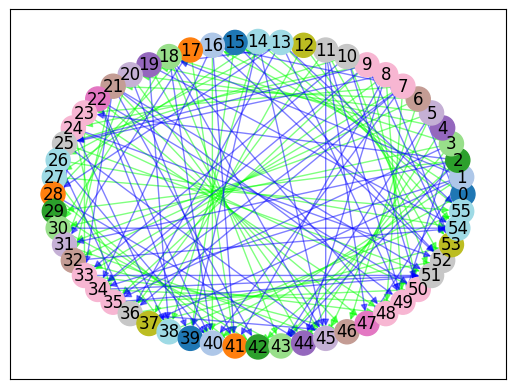

In [159]:
from modules.torch_dataset.utils import draw_pyg_network

draw_pyg_network(data, [0, 1])

In [7]:
import torch

def torch_isin(input, test_elements):
    # Create a boolean mask of the same shape as 'input'
    mask = torch.zeros_like(input, dtype=torch.bool)

    # Loop through each element in 'test_elements' and set the corresponding
    # elements in 'mask' to True if they match any element in 'input' along the specified dimension
    for element in test_elements:
        mask = mask | (input == element)
    
    return mask

In [13]:
torch_isin(torch.tensor([[[1,2,3], [4,5,6]], [[24,5,6], [6,7,8]]]), torch.tensor([3,4,5]))

tensor([[[False, False,  True],
         [ True,  True, False]],

        [[False,  True, False],
         [False, False, False]]])

In [9]:
torch.isin(torch.tensor([[1,2,3], [4,5,6]]), torch.tensor([3,4,5]))

tensor([[False, False,  True],
        [ True,  True, False]])